# Time series analysis: NYC Second Ave subway impact in taxi ridership

#### Imports

In [1]:
import os
from downloader import download_file

import pandas as pd
import geopandas as gpd

import numpy as np
import statsmodels.api as sma

import pylab as pl
import seaborn as sns
sns.set(context='notebook', style='ticks', palette='deep', font='DejaVu Sans', font_scale=1.2, rc=None)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


#### Set data directory

In [2]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "{}/data/PUIdata".format(os.getenv("HOME"))
    puidata = os.getenv("PUIDATA")
    print("Warning: PUIDATA environmental variable not found and set by code, please review!")
print("PUIDATA: {}".format(puidata))

PUIDATA: /nfshome/pmb434/PUIdata


## Define taxi zones to analyze

In [3]:
#Download TLC taxi zone shapefile
taxi_zones_files = download_file(url='https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip',
                                 filename='taxi_zones.zip',
                                 destination=puidata)
taxi_zones_shp = gpd.read_file(taxi_zones_files[2])

taxi_zones_shp.head()

File already downloaded.
File already extracted.
taxi_zones.zip contents in place, you can continue.


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."


In [4]:
#Download MTA subway stations shapefile
subway_lines_files = download_file(url='https://data.cityofnewyork.us/api/geospatial/arq3-7z49?method=export&format=Shapefile',
                                   filename='subway_lines.zip',
                                   destination=puidata)
subway_lines_shp = gpd.read_file(subway_lines_files[2])

subway_lines_shp.to_crs(epsg=2263, inplace=True)

subway_lines_shp.head()

File already downloaded.
File already extracted.
subway_lines.zip contents in place, you can continue.


,line,name,notes,objectid,url,geometry
0,4-6-6 Express,Astor Pl,"4 nights, 6-all times, 6 Express-weekdays AM s...",1.0,http://web.mta.info/nyct/service/,POINT (986725.0019278985 205255.0527942391)
1,4-6-6 Express,Canal St,"4 nights, 6-all times, 6 Express-weekdays AM s...",2.0,http://web.mta.info/nyct/service/,POINT (984196.5000951464 201155.8398640769)
2,1-2,50th St,"1-all times, 2-nights",3.0,http://web.mta.info/nyct/service/,POINT (988724.2161053148 216795.1908031626)
3,2-3-4,Bergen St,"4-nights, 3-all other times, 2-all times",4.0,http://web.mta.info/nyct/service/,POINT (991184.2459621441 187333.8442141615)
4,3-4,Pennsylvania Ave,"4-nights, 3-all other times",5.0,http://web.mta.info/nyct/service/,POINT (1013411.540746317 181467.289018167)


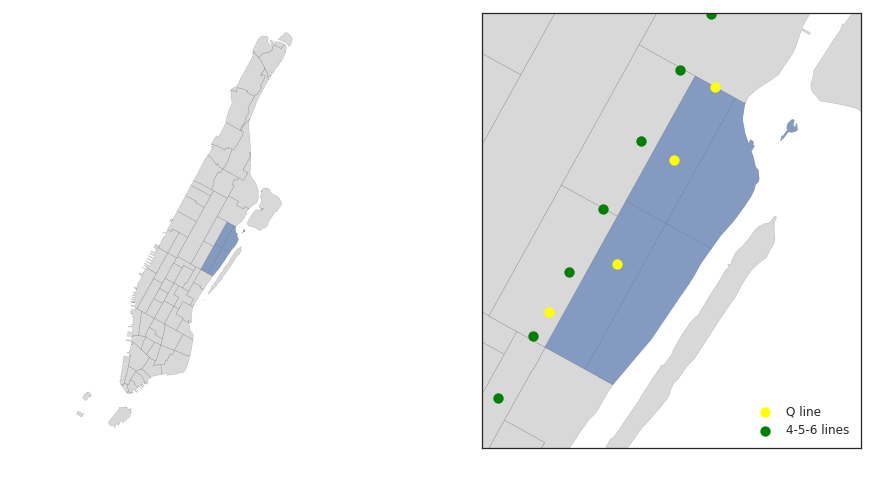

In [5]:
#taxi zones nearby new stations
impacted = [140,141,263,262]

fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize  = (16, 8))

#ax.set_title("Impacted zone", fontsize=15)
taxi_zones_mn = taxi_zones_shp[taxi_zones_shp.borough == 'Manhattan']
taxi_zones_impacted = taxi_zones_shp[taxi_zones_shp.LocationID.isin(impacted)]

#Manhattan
taxi_zones_mn.plot(ax=ax1, color='grey', edgecolor='black', alpha=0.3)
taxi_zones_impacted.plot(ax=ax1, alpha=0.6)

ax1.axis('off')
ax1.axes.set_aspect('equal')

#Impacted area zoomed in
minx, miny, maxx, maxy = taxi_zones_impacted.total_bounds
delta = 2000
ax2.set_xlim(minx - delta, maxx + delta)
ax2.set_ylim(miny- delta, maxy + delta)

taxi_zones_mn.plot(ax=ax2, color='grey', edgecolor='black', alpha=0.3)
taxi_zones_impacted.plot(ax=ax2, alpha=0.6)

subway_lines_shp[subway_lines_shp.line.str.contains('Q')].plot(ax=ax2, color='yellow', markersize=100, label='Q line')
subway_lines_shp[subway_lines_shp.line.str.contains('4')].plot(ax=ax2, color='green', markersize=100, label='4-5-6 lines')

ax2.set_xticks([])
ax2.set_yticks([])
ax2.axes.set_aspect('equal')
ax2.legend(loc=4)

pl.show()

**Figure 1: TLC Taxi Zones to be analyzed.** The map shows Manhattan divided into the TLC's defined Taxi Zones. The four Taxi Zones highlighted are the ones where the new 2nd Ave Stations of the Q-line are located, as it can be seen in the zoomed map on the right. These are the Taxi Zones used for the analysis.

## Data exploration and analysis

#### Load TLC trips dataset

This is a preprocessed dataset with daily pickups from Jul-2014 to Jun-2018 for each Taxi Zone around the new 2nd Ave. subway stations. Only considers pickups by yellow taxis.

In [6]:
final_df = pd.read_csv(puidata + '/yellowtaxi_all.csv', parse_dates=[1])
final_df.sort_values(by='date', inplace=True)
final_df.head()

,PULocationID,date,passenger_count
0,75.0,2014-07-01,3607.0
62,141.0,2014-07-01,16915.0
93,236.0,2014-07-01,23021.0
124,237.0,2014-07-01,28299.0
155,262.0,2014-07-01,8250.0


In [7]:
#Select the four taxi zones shown above
final_df['impacted'] = final_df.PULocationID.isin(impacted).astype(int)

#Group to analyze the area as a whole
final_df_grouped = final_df.groupby(['impacted','date'], as_index=False)[['passenger_count']].sum()
impacted_timeseries = final_df_grouped.loc[final_df_grouped.impacted == 1, ['date', 'passenger_count']]
impacted_timeseries.set_index('date', inplace=True)
impacted_timeseries.head()

,passenger_count
date,
2014-07-01,50352.0
2014-07-02,52351.0
2014-07-03,50435.0
2014-07-04,33459.0
2014-07-05,29101.0


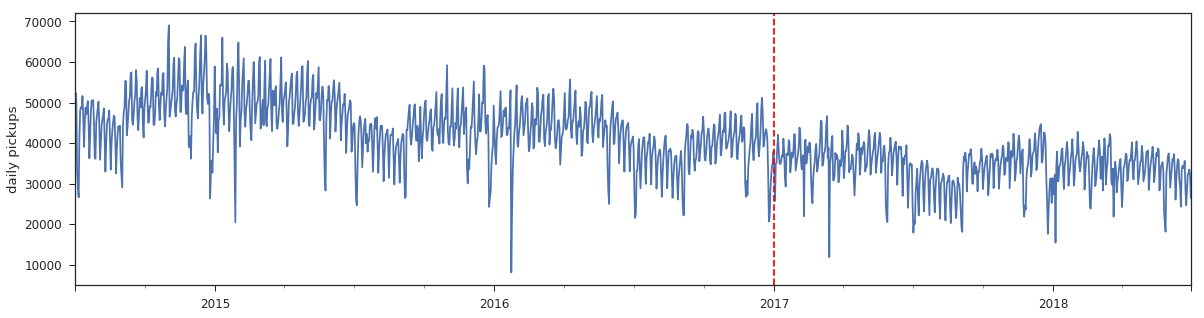

In [8]:
fig, (ax1) = pl.subplots(1,1, figsize=(20,5))

#Plot
impacted_timeseries.plot(y='passenger_count', ax=ax1, legend=False)

ax1.axvline(x=pd.datetime(2017,1,1), color='r', ls='--')

ax1.set_ylabel('daily pickups')
ax1.set_xlabel('')

pl.show()

**Figure 2: Time series of daily taxi pickups from analyzed area.** The graph above shows that the daily pickups in the area have been decreasing over the years, with a marked yearly seasonality. The red vertical line shows the day when the new subway stations openned. Because of the downward trend and seasonality, it is not easy to recognize visually if there was a significant decrease in taxi ridership after that date. 

### Periodicity assessment using Fourier transform

This transformation takes the timeseries from a time space to a frequency space, where higher values indicate a strong periodicity at the given frequency.

In [9]:
power_spectrum = (np.fft.rfft(impacted_timeseries.passenger_count).real)**2

top_freqs = np.argsort(-power_spectrum)[1:4]

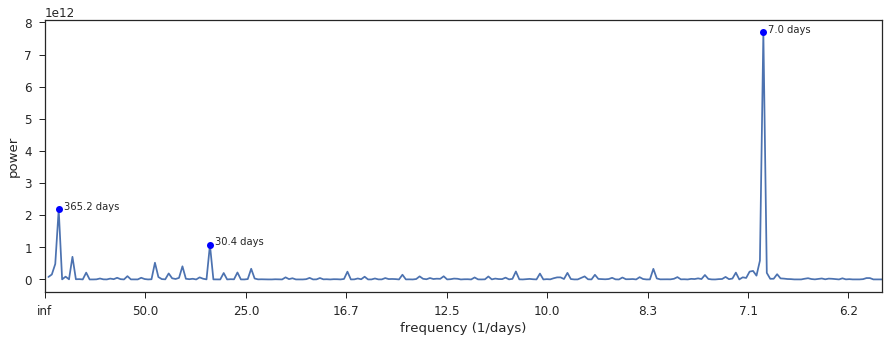

In [10]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.set_xlim(right=1/6)

#Plot the power spectrum
ax.plot(np.fft.rfftfreq(len(impacted_timeseries))[1:], power_spectrum[1:], '-')
ax.plot(np.fft.rfftfreq(len(impacted_timeseries))[top_freqs], power_spectrum[top_freqs], 'o', color='b')

#Anotate top 3
for f in top_freqs:
    ax.annotate(s='{:.1f} days'.format(1/np.fft.rfftfreq(len(impacted_timeseries))[f]),
                xy=(np.fft.rfftfreq(len(impacted_timeseries))[f]+1e-3, power_spectrum[f]))

ax.set_xticklabels([ "{:.1f}".format(1/f) for f in ax.get_xticks()])
pl.ylabel("power")
pl.xlabel("frequency (1/days)");

**Figure 3: Power spectrum from Fourier transformation of the timeseries.** The graph shows that taxi pickups have a strong periodicity weekly, yearly and monthly; these are the three highes peaks in the power spectrum.

### Visualization of weekly periodicity

In [11]:
#Get week info for each day
impacted_timeseries['weekday_name'] = impacted_timeseries.index.weekday_name
impacted_timeseries['weekday'] = impacted_timeseries.index.weekday
impacted_timeseries['year'] = impacted_timeseries.index.year
impacted_timeseries['week_year'] = impacted_timeseries.index.weekofyear.astype('str') + \
                                    impacted_timeseries.year.astype('str').apply(lambda x: '-' + x)

#Calculate a weekly strandardized number of pickups for visualization
weekly_mean = impacted_timeseries.resample('W-SUN').mean().resample('D').bfill()['passenger_count'][1:]
weekly_std = impacted_timeseries.resample('W-SUN').std().resample('D').bfill()['passenger_count'][1:]

impacted_timeseries['p_count_norm_w'] = (impacted_timeseries.passenger_count - weekly_mean) / weekly_std

impacted_timeseries.head(10)

,passenger_count,weekday_name,weekday,year,week_year,p_count_norm_w
date,,,,,,
2014-07-01,50352.0,Tuesday,1,2014,27-2014,NaN
2014-07-02,52351.0,Wednesday,2,2014,27-2014,NaN
2014-07-03,50435.0,Thursday,3,2014,27-2014,NaN
2014-07-04,33459.0,Friday,4,2014,27-2014,NaN
2014-07-05,29101.0,Saturday,5,2014,27-2014,NaN
2014-07-06,26615.0,Sunday,6,2014,27-2014,NaN
2014-07-07,41227.0,Monday,0,2014,28-2014,-1.126623
2014-07-08,48136.0,Tuesday,1,2014,28-2014,0.409560
2014-07-09,48857.0,Wednesday,2,2014,28-2014,0.569871


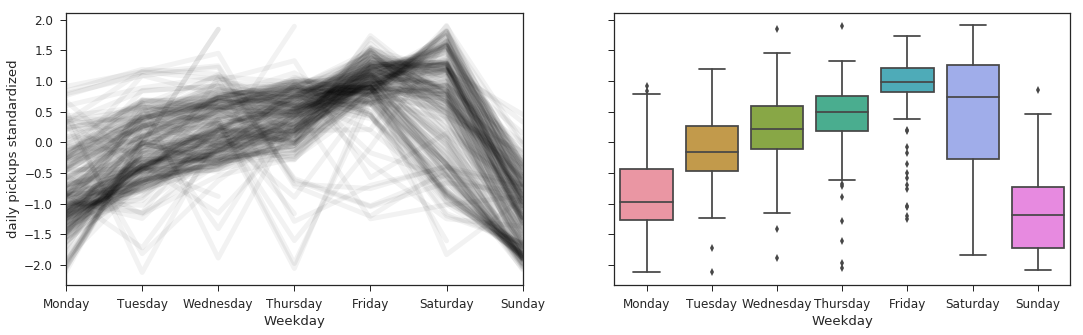

In [12]:
fig, (ax1, ax2) = pl.subplots(1,2, figsize=(18,5), sharey=True)

#Plot
impacted_timeseries.groupby('week_year').apply(
    lambda x: x.plot(x='weekday_name', y='p_count_norm_w', ax=ax1, legend=False, color='k', alpha=0.05, lw=5))

sns.boxplot(data=impacted_timeseries, x='weekday', y='p_count_norm_w', ax=ax2)

ax1.set_ylabel('daily pickups standardized')
ax2.set_xticklabels(ax1.get_xticklabels())

ax1.set_xlabel('Weekday')
ax2.set_xlabel('Weekday')

ax1.set_xlim(right=6)

pl.show()

**Figure 4: Daily taxi pickups by weekday.** The data has been standardized per week to allow comparison removing higher seasonality and overall downward trend. The left graph each line is a single week, and in the left graph the same information is displayed as a boxplot for every weekday. Most weeks have the same pattern of taxi pickups: the day with the least rides is Sunday and it goes up every day until peaking on Friday. Some weeks have a different pattern, which could be due to holidays. 

### Visualization of yearly periodicity

In [13]:
#Calculate a moving average with a 7 day window to smooth the time series removing the weekly periodicity
impacted_timeseries['moving_average'] = impacted_timeseries.passenger_count.rolling(7, center=True, min_periods=1).mean()

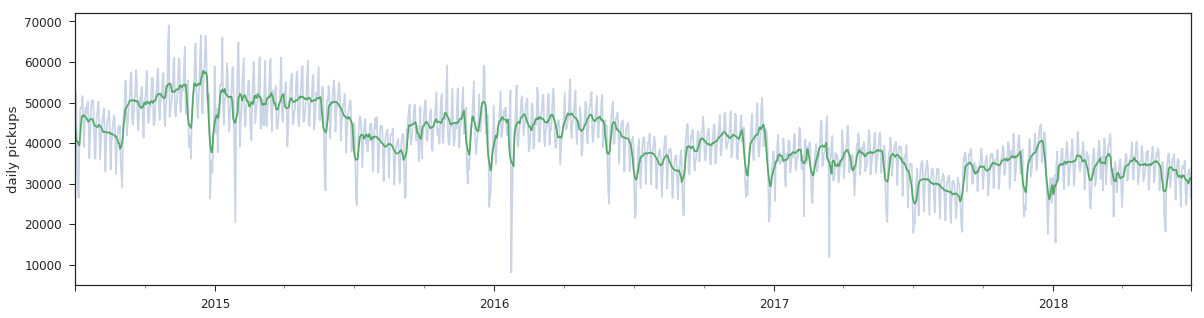

In [14]:
fig, (ax1) = pl.subplots(1,1, figsize=(20,5))

#Plot
impacted_timeseries.plot(y='passenger_count', ax=ax1, legend=False, alpha=0.3)
impacted_timeseries.plot(y='moving_average', ax=ax1, legend=False)

ax1.set_ylabel('daily pickups')
ax1.set_xlabel('')

pl.show()

**Figure 5: Smoothed timeseries to remove weekly periodicity.** The green line shows the timeseries smoothed by a 7-day moving average, which removes the weekly periodicity. It is easier to see now the downward trend and to recognize yearly patterns.

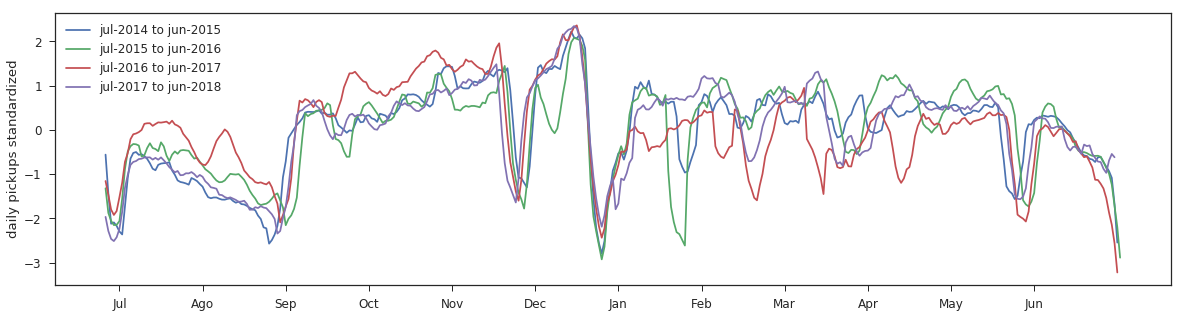

In [15]:
fig, (ax1) = pl.subplots(1,1, figsize=(20,5))

for y in range(2014,2018):
    impacted_timeseries_part = impacted_timeseries.loc['{}-7-1'.format(y):'{}-7-1'.format(y+1)]
    timeseries = impacted_timeseries_part.moving_average.values
    
    timeseries = (timeseries - timeseries.mean())/timeseries.std()
    
    ax1.plot(range(len(timeseries)), timeseries, label='jul-{} to jun-{}'.format(y,y+1))


ax1.set_xticks(range(5,365,30))
ax1.set_xticklabels(['Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
ax1.set_ylabel('daily pickups standardized')
ax1.legend()
pl.show()

**Figure 6: Daily taxi pickups by annual period from July to June next year.** The data has been standardized per annual period to allow comparison removing overall downward trend. The graph shows visually that there is a strong yearly seasonality in taxi pickups: ridership goes down over the summer and there is a sharp increase in September when summer ends. There is also a deep decrease around Thanksgiving, Chrismas and New Year holidays.

### Seasonality and trend

The Hodrick-Prescott filter is used to separate cycle from trend in the timeseries.

In [16]:
cycle, trend = sma.tsa.filters.hpfilter(impacted_timeseries.moving_average, lamb = 104976000000 )
impacted_timeseries['cycle'] = cycle
impacted_timeseries['trend'] = trend

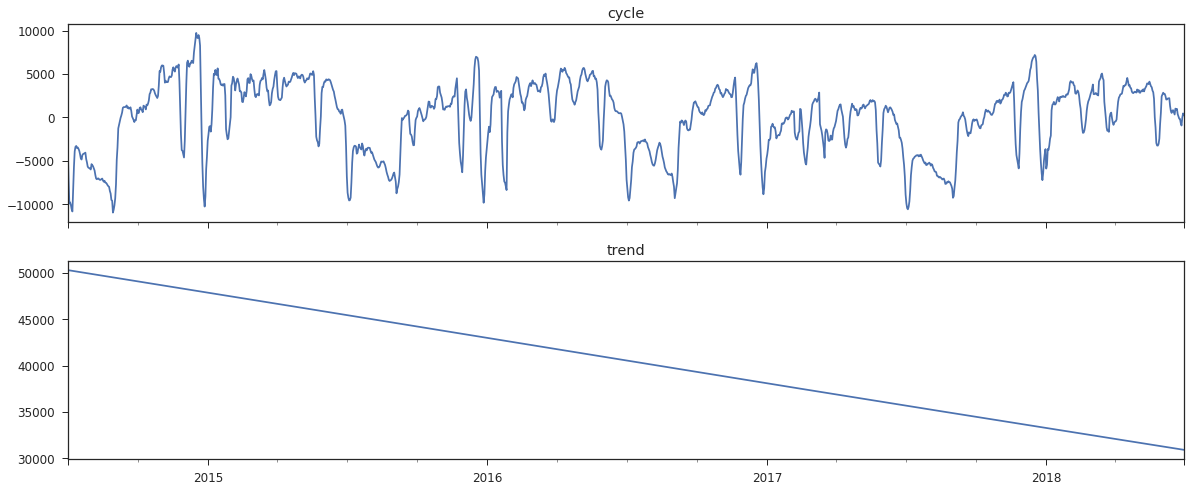

In [17]:
fig, (ax1, ax2) = pl.subplots(2,1, figsize=(20,8), sharex=True)

#Plot
impacted_timeseries.plot(y='cycle', ax=ax1, legend=False, title='cycle')
impacted_timeseries.plot(y='trend', ax=ax2, legend=False, title='trend')

ax2.set_xlabel('')

pl.show()

**Figure 7: Cycle and trend from daily taxi pickups.** As seen before, there is a strong downward trend in the taxi pickups. This could be due to the increase in use of ride-hailing apps like Uber or Lyft. The presence of this downward trend and the seasonality can make it more difficult to detect if the openning of the Second Ave subway station had an impact in taxi ridership.

### Point of change detection

A bayesian inference approach to detect a point of change is used. It calculates the pre and post mean for every point in the timeseries, and the likelihood that the change in mean is significant.

In [18]:
# Single point change detector
# function by Dr. Federica Bianco as found here: 
# https://github.com/fedhere/UInotebooks/blob/master/timeseries/pointOfChange.ipynb

def changeFinder(data):

    n = len(data)
    datamean = data.mean()
    datasqmean = (data**2).mean()
    fac = datasqmean - datamean**2
    
    datacsum = data.cumsum()
    datasum = datacsum[-1]

    ppoc = np.zeros(n) #container for point of change relative prob

    #online (iterative) search for point of change
    for m in range(n-1):
        pos = m + 1
        relativePosition = (pos) * (n - pos)
 
        Q = datacsum[m] - (datasum - datacsum[m]) #cumsum up to m - cumsum after
        
        U = -(datamean * (n - 2 * pos) + Q)**2 / (4.0 * relativePosition) + fac
       
        ppoc[m+1] = (-(n * 0.5 - 1) * np.log(n * U * 0.5) - 
                 0.5 * np.log(relativePosition))

    ppoc[0] = min(ppoc[1:])
    changePoint = np.argmax(ppoc)
    
    return {'pChange': ppoc, 
            'pointOfChange': changePoint + 1,
            'meanBefore': (data[:changePoint+1]).mean(), 
            'meanAfter': (data[(changePoint+1):]).mean()}

In [19]:
timeseries = impacted_timeseries.moving_average.values
dates = impacted_timeseries.index
pochange = changeFinder(timeseries)
pochange['pointOfChange']

727

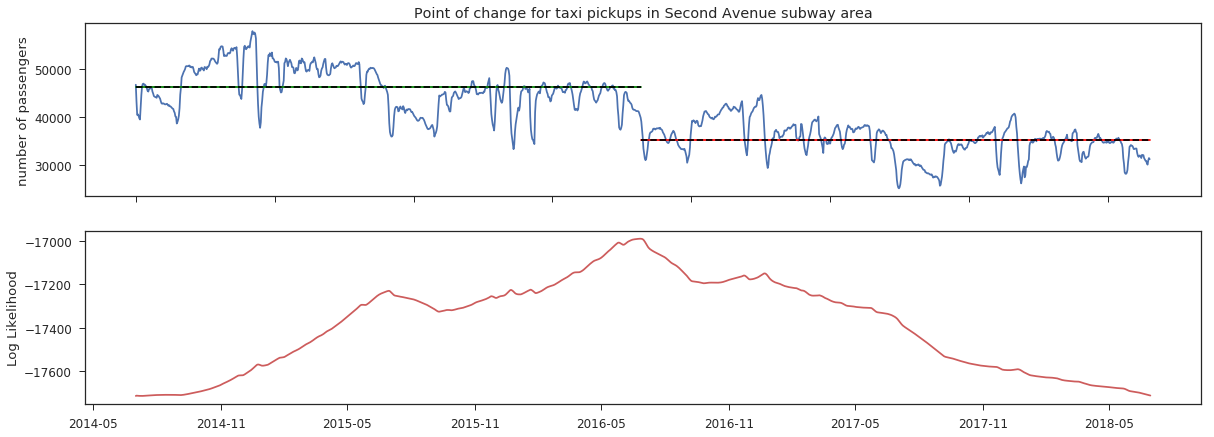

In [20]:
fig = pl.figure(figsize=(20,7))
ax1 = pl.subplot(211)
ax1.plot(range(len(timeseries)), timeseries)

ax1.plot([0,pochange['pointOfChange']], 
         [pochange['meanBefore'], pochange['meanBefore']], 'g-')
ax1.plot([pochange['pointOfChange'],len(timeseries)], 
         [pochange['meanAfter'], pochange['meanAfter']], 'r-')
ax1.plot([0,pochange['pointOfChange']], 
         [pochange['meanBefore'], pochange['meanBefore']], 'k--')
ax1.plot([pochange['pointOfChange'],len(timeseries)], 
         [pochange['meanAfter'], pochange['meanAfter']], 'k--')
ax1.set_xticklabels(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel("number of passengers")

ax1.set_title("Point of change for taxi pickups in Second Avenue subway area")

ax2 = pl.subplot(212)
ax2.plot(dates, 
        pochange['pChange'], color="IndianRed")
ax2.set_ylabel("Log Likelihood");

**Figure 8: Point of change detection with the complete smoothed timeseries.** The bottom graph shows the likelihood for every day to be a significant point of change in the timeseries, with the highest peak at the beggining of June 2016. The top graph displays the smoothed timeseries, with a green line for the mean before the detected point of change and a red line for the mean after. Even though this is not the date we hoped to find, the second peak in the bottom graph is at the beggining of 2017. Also, the fact that there is a strong downward trend biases the point of change detector towards the middle of the timeseries, with the added issue of the seasonal decrease every year when summer starts in June.

To counter this, I will do the point of change detection for every year separately.

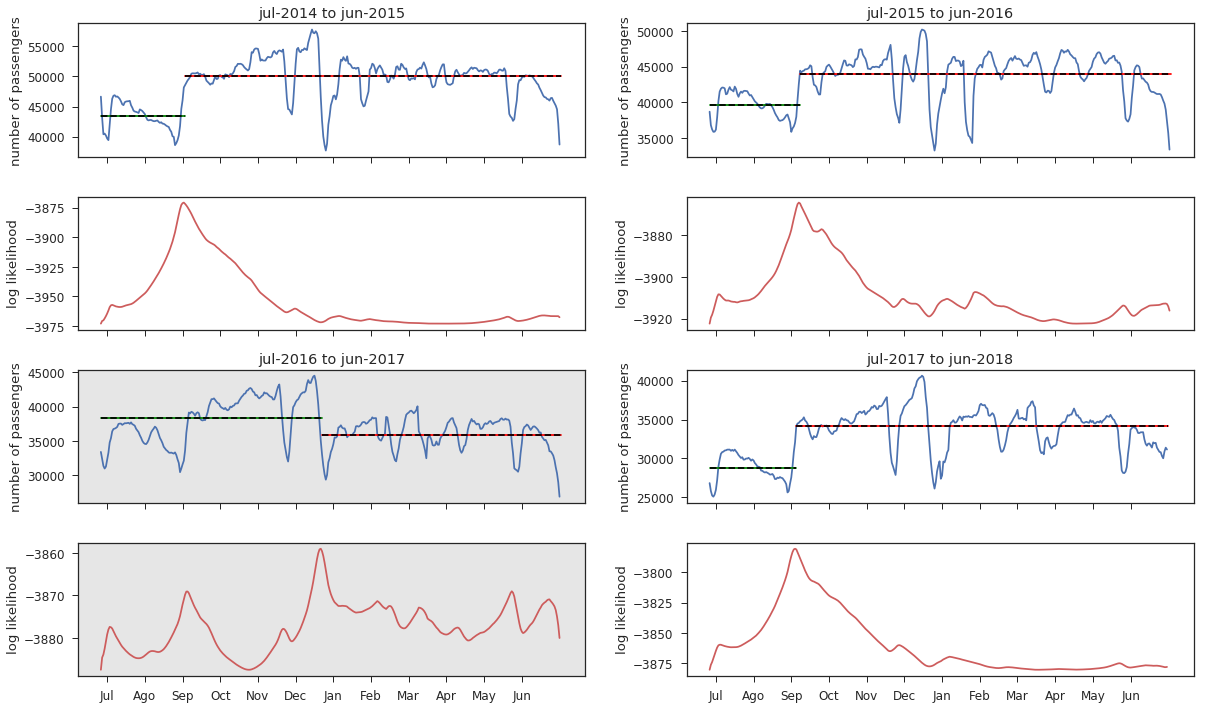

In [27]:
fig, axes = pl.subplots(4,2, figsize=(20,12), sharex=True)
fig.subplots_adjust(hspace=0.3)

for y in range(2014,2018):
    impacted_timeseries_part = impacted_timeseries.loc['{}-7-1'.format(y):'{}-7-1'.format(y+1)]

    timeseries = impacted_timeseries_part.moving_average.values
    dates = impacted_timeseries_part.index
    pochange = changeFinder(timeseries)
    pochange['pointOfChange']
    
    row = 2*((y-2014)//2)
    col = 0 if y % 2 == 0 else 1
    
    ax1 = axes[row, col]
              
    ax1.plot(range(len(timeseries)), timeseries)
    #ax1.plot([0,100], [0,0], '-')
    #ax1.plot([100,200], [3,3], '-')

    ax1.plot([0,pochange['pointOfChange']], 
             [pochange['meanBefore'], pochange['meanBefore']], 'g-')
    ax1.plot([pochange['pointOfChange'],len(timeseries)], 
             [pochange['meanAfter'], pochange['meanAfter']], 'r-')
    ax1.plot([0,pochange['pointOfChange']], 
             [pochange['meanBefore'], pochange['meanBefore']], 'k--')
    ax1.plot([pochange['pointOfChange'],len(timeseries)], 
             [pochange['meanAfter'], pochange['meanAfter']], 'k--')
    #ax1.set_xticklabels(ax1.get_xticklabels(), visible=False)
    ax1.set_ylabel("number of passengers")

    ax1.set_title('jul-{} to jun-{}'.format(y,y+1))

    ax2 = axes[row+1, col]
    ax2.plot(pochange['pChange'], color="IndianRed")
    
    ax2.set_ylabel("log likelihood")
    ax2.set_xlabel("")
    ax2.set_xticks(range(5,365,30))
    ax2.set_xticklabels(['Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

axes[2,0].set_facecolor('0.9')
axes[3,0].set_facecolor('0.9')

**Figure 9: Point of change detection for each annual period from July to June next year.** Each pair of graphs is the same as in the previous figure, but for an annual period. It is interesting to see that only on the graphs for jul-2016 to jun-2017 the detected point of change is in New Year: when the Second Ave. subway stations were opened. On the other hand, all the other annual periods show the end of the summer as the higher point of change. It is important to note that because now all the graphs have New Year as the middle of the timeseries and all have a downward trend, the bias toward selecting the middle of the timeseries as a point of change is still present.

## Next steps

The analysis could be improved in a number of ways. Some possible next steps could be:

- Include for-hire vehicles and ride-hailing apps to the analysis.
- Increase the scope of analysis to include more years.
- Compare with similar areas in the city that weren't impacted by the new subway stations.